# Taxonomic Comparison and Quantitative Assessment of Viral Diversity in Contrasting Aquatic Environments of Cuatro Ciénegas
---
---

## I. Introduction

This notebook addresses the central research question:
How does nutrient enrichment influence the taxonomic composition and diversity of viral communities in the aquatic ecosystems of the Cuatro Ciénegas Basin?

By comparing the viromes from a control pond (JC1A) and a fertilized pond (JP4D), we aim to reveal differences in composition and diversity profiles, thus, offering important perspectives into microbial ecology and responses to environmental disturbances.

---

## II. Methodology
- Load and preprocess Kraken2 viral classification data for samples JC1A and JP4D.
- Annotate taxonomic identifiers using the NCBI viral taxonomy.
- Compare the presence and relative abundances of viral taxa between samples.
- Calculate Shannon and Simpson diversity indices and Bray-Curtis distance for quantitative assessment.
- Visualize differences in the abundance of shared taxa.
- Interpret results in the ecological context of nutrient enrichment.

---

## III. Data import and Processing

#### **A- Libraries Import and Seting Tools**

In [1]:
# Libraries import
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# Tools Functions and datasets

#--------------Functions-------------------------------------------------------

def reads_classified(df):
    """
    Filter the dataframe to keep only rows where the 'status' column equals 'C'.
    Likely used to keep only classified reads.
    """
    return df[df.status == 'C']


def unique_taxon(df):
    """
    Return the unique elements from the dataframe.
    If you pass a Series or a specific column, this will return the unique taxon IDs.
    """
    return df.unique()


def group_by_tax_id(df, col):
    """
    Group the dataframe by the values of the specified column 'col'.
    Count the number of occurrences for each unique value.
    Sort counts in descending order.
    Return:
        - the unique tax IDs (index),
        - their counts,
        - their relative percentages rounded to 2 decimals.
    """
    group = df.groupby(col).size().sort_values(ascending=False)
    return (
        group.index,
        group.values,
        np.round(100 * group.values / group.values.sum(), 2)
    )


def table_grouped_with_percent(df, col):
    """
    Create a summary table grouped by 'col', with counts and percentages.
    Returns a pandas DataFrame with columns:
        - 'tax_id': unique tax IDs
        - 'count_class': number of occurrences
        - 'percent': relative percentage
    """
    idx, val, nbr = group_by_tax_id(df, col)
    dico = {'tax_id': idx, 'count_class': val, 'percent': nbr}
    return pd.DataFrame(dico)


#-----------------Datasets---------------------------------------------------------

# Initialize lists to collect parsed records
records_name = []
records_node = []

# Read and parse the names.dmp file
with open("names.dmp", "r") as file_name:
    for line in file_name:
        # Split line by '|', remove whitespace
        fields = [x.strip() for x in line.split("|")]
        # Keep only entries with the label 'scientific name'
        if fields[3] == "scientific name":
            records_name.append((fields[0], fields[1]))

# Convert to a DataFrame with tax IDs and scientific names
names_df = pd.DataFrame(records_name, columns=["tax_id", "name_txt"])

# Read and parse the nodes.dmp file
with open("nodes.dmp", "r") as f:
    for line in f:
        fields = [x.strip() for x in line.split("|")]
        tax_id = fields[0]
        parent_tax_id = fields[1]
        rank = fields[2]
        records_node.append((tax_id, parent_tax_id, rank))

# Convert to a DataFrame with tax IDs, parent IDs, and taxonomic ranks
nodes_df = pd.DataFrame(records_node, columns=["tax_id", "parent_tax_id", "rank"])

#### **B- Data import**
Read the Kraken classification output files into a pandas DataFrame.

    case1: 'JC1A_output.txt' 
    case2:'JP4D_output.txt'  
- The files are located in the directory 'returned_files/kraken/'.
- Fields in the file are separated by tabs ('\t').
- The file does NOT have a header row, so we provide custom column names: 'status' : classification status (e.g., 'C' for classified, 'U' for unclassified) 'read_id' : unique identifier of the read 'tax_id' : taxonomic ID assigned to the read 'alignment_Info' : information about the alignment 'details' : additional details about the classification
- Encoding is set to 'latin1' to handle any special characters.

##### **Case1: JC1A**

In [3]:
jc1a_output = pd.read_csv(
    'returned_files/kraken/JC1A_output.txt',
    sep='\t',
    header=None,
    names=['status', 'read_id', 'tax_id', 'alignment_Info', 'details'],
    encoding='latin1'
)

# Display the first 2 rows of the DataFrame to quickly inspect the contents.
jc1a_output.head(n=2)

,status,read_id,tax_id,alignment_Info,details
0,U,MISEQ-LAB244-W7:91:000000000-A5C7L:1:1101:1341...,0,151|190,A:17 0:100 |:| 0:3 A:53 0:100
1,U,MISEQ-LAB244-W7:91:000000000-A5C7L:1:1101:1578...,0,169|173,0:135 |:| 0:139


##### **Case2: JP4D**

In [4]:
# Read the file in chunks of 100,000 rows
chunks = pd.read_csv(
    'returned_files/kraken/JP4D_output.txt',
    sep='\t',
    header=None,
    names=['status', 'read_id', 'tax_id', 'alignment_Info', 'details'],
    encoding='latin1',
    chunksize=100000
)

# Concatenate all chunks into a single DataFrame
jp4d_output = pd.concat(chunks, ignore_index=True)

# Display the first 2 rows to verify
jp4d_output.head(n=2)

,status,read_id,tax_id,alignment_Info,details
0,U,MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:126...,0,142|142,0:108 |:| 0:108
1,U,MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:173...,0,198|198,0:164 |:| 0:164


#### **C- Filter Classified Reads**
- Use the previously defined function 'reads_classified' to filter the DataFrames:
- Keep only the rows where the 'status' column equals 'C' (classified reads).
- Display the first 3 classified reads to check the result.

##### **Case1: JC1A**

In [5]:
jc1a_output_classifed = reads_classified(jc1a_output)
jc1a_output_classifed.head(3)

,status,read_id,tax_id,alignment_Info,details
294,C,MISEQ-LAB244-W7:91:000000000-A5C7L:1:1101:1308...,67082,250|250,0:157 67082:13 0:46 |:| 0:59 67082:13 0:144
319,C,MISEQ-LAB244-W7:91:000000000-A5C7L:1:1101:9713...,67082,233|233,0:117 67082:1 0:5 67082:1 0:75 |:| 0:75 67082:...
889,C,MISEQ-LAB244-W7:91:000000000-A5C7L:1:1101:1520...,10682,251|251,10682:217 |:| 10682:24 0:13 10682:2 0:8 10682:...


##### **Case2: JP4D**

In [6]:
# Prepare an empty list to collect filtered chunks
classified_chunks = []

# Read and process chunk by chunk
for chunk in pd.read_csv(
    'returned_files/kraken/JP4D_output.txt',
    sep='\t',
    header=None,
    names=['status', 'read_id', 'tax_id', 'alignment_Info', 'details'],
    encoding='latin1',
    chunksize=100000
):
    # Keep only classified reads in this chunk
    classified = reads_classified(chunk)
    
    # Append to our list (you could also write to disk here instead)
    classified_chunks.append(classified)

# Concatenate all classified rows into a single DataFrame
jp4d_output_classified = pd.concat(classified_chunks, ignore_index=True)

# Display the first 3 rows
jp4d_output_classified.head(3)

,status,read_id,tax_id,alignment_Info,details
0,C,MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:189...,2594900,251|190,0:114 2594900:8 0:95 |:| 0:122 2594900:8 0:26
1,C,MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:175...,10847,251|249,10847:34 0:3 10847:1 0:17 10847:3 0:5 10847:47...
2,C,MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:134...,10847,251|250,10847:168 1910950:6 10847:43 |:| 10847:68 1910...


#### **D- Taxonomy Aggregation**
##### **Objective: Group Classified Reads by Taxonomic ID and Calculate Percentages**
Use the function 'table_grouped_with_percent' to:
 - Group the classified reads by their taxonomic ID ('tax_id').
 - Count how many reads are assigned to each tax ID.
 - Calculate the relative percentage for each tax ID.

 The result is a summary table showing tax ID, count, and percentage of classified reads.

 Display the first 5 rows of this summary table to inspect the most abundant taxa.

##### **Case1: JC1A**

In [7]:
jc1a_group = table_grouped_with_percent(jc1a_output_classifed, jc1a_output_classifed.tax_id)
jc1a_group.head()

,tax_id,count_class,percent
0,67082,352,39.82
1,10847,132,14.93
2,518987,77,8.71
3,10682,63,7.13
4,1883370,24,2.71


##### **Case2: JP4D**

In [9]:
jp4d_group = table_grouped_with_percent(jp4d_output_classified, jp4d_output_classified.tax_id)
jp4d_group.head()

,tax_id,count_class,percent
0,10847,1761,51.55
1,56947,38,1.11
2,2560160,33,0.97
3,754056,32,0.94
4,10662,27,0.79


#### **E- Taxonomy annotation**
##### **Objective: Annotate Counts Table with Scientific Taxon Names**

- Prepare both DataFrames for merging by ensuring 'tax_id' columns are strings
and stripping any leading/trailing whitespace.
- Merge the grouped taxa tables (jc1a_group and jp4d_group) with the taxonomy names table (names_df)
on the 'tax_id' column.
- Use a left join to keep all counts, adding the scientific name if available.

##### **Case1: JC1A**

In [11]:
jc1a_group['tax_id'] = jc1a_group['tax_id'].astype(str).str.strip()
names_df['tax_id'] = names_df['tax_id'].astype(str).str.strip()
jc1a_annoted = jc1a_group.merge(names_df, on='tax_id', how='left')
jc1a_annoted.head()

,tax_id,count_class,percent,name_txt
0,67082,352,39.82,BeAn 58058 virus
1,10847,132,14.93,Sinsheimervirus phiX174
2,518987,77,8.71,Influenza B virus (B/Lee/1940)
3,10682,63,7.13,Enterobacteria phage P7
4,1883370,24,2.71,Erwinia phage vB_EamM_Asesino


##### **Case2: JP4D**

In [12]:
jp4d_group['tax_id'] = jp4d_group['tax_id'].astype(str).str.strip()
names_df['tax_id'] = names_df['tax_id'].astype(str).str.strip()
jp4d_annoted = jp4d_group.merge(names_df, on='tax_id', how='left')
jp4d_annoted.head()

,tax_id,count_class,percent,name_txt
0,10847,1761,51.55,Sinsheimervirus phiX174
1,56947,38,1.11,Choristoneura fumiferana granulovirus
2,2560160,33,0.97,Kochikohdavirus
3,754056,32,0.94,Rhodovulum phage RS1
4,10662,27,0.79,NaN


---

## IV. Taxonomy Comparison
#### **Objective: Visualize and compare the abundance of viruses shared between the two samples.**
- Merge the taxonomic abundance tables.
- Replace missing values with zero.
- Identify shared taxa.
- Sort by decreasing abundance.
- Create the comparative bar chart.
- Interpretation
- Conclusion



In [43]:
# Merge JC1A and JP4D annotations on tax_id and name
comparison_taxon = pd.merge(
    jc1a_annoted[['tax_id', 'name_txt', 'percent']],
    jp4d_annoted[['tax_id', 'name_txt', 'percent']],
    on=['tax_id', 'name_txt'],
    how='outer',
    suffixes=('_jc1a', '_jp4d')
)
# Replace NaN with 0 (species absent in one sample)
comparison_taxon[['percent_jc1a', 'percent_jp4d']] = comparison_taxon[['percent_jc1a', 'percent_jp4d']].fillna(0)
comparison_taxon.head(2)

,tax_id,name_txt,percent_jc1a,percent_jp4d
0,1000373,Rosellinia necatrix quadrivirus 1,0.0,0.03
1,1003177,Vibrio phage qdvp001,0.0,0.03


In [44]:
# Keep only shared taxa (present in both)
shared = comparison_taxon[(comparison_taxon['percent_jc1a'] > 0) & (comparison_taxon['percent_jp4d'] > 0)]
shared.head(2)

,tax_id,name_txt,percent_jc1a,percent_jp4d
33,10682,Enterobacteria phage P7,7.13,0.03
42,10847,Sinsheimervirus phiX174,14.93,51.55


#### Visualization of Taxonomic Composition

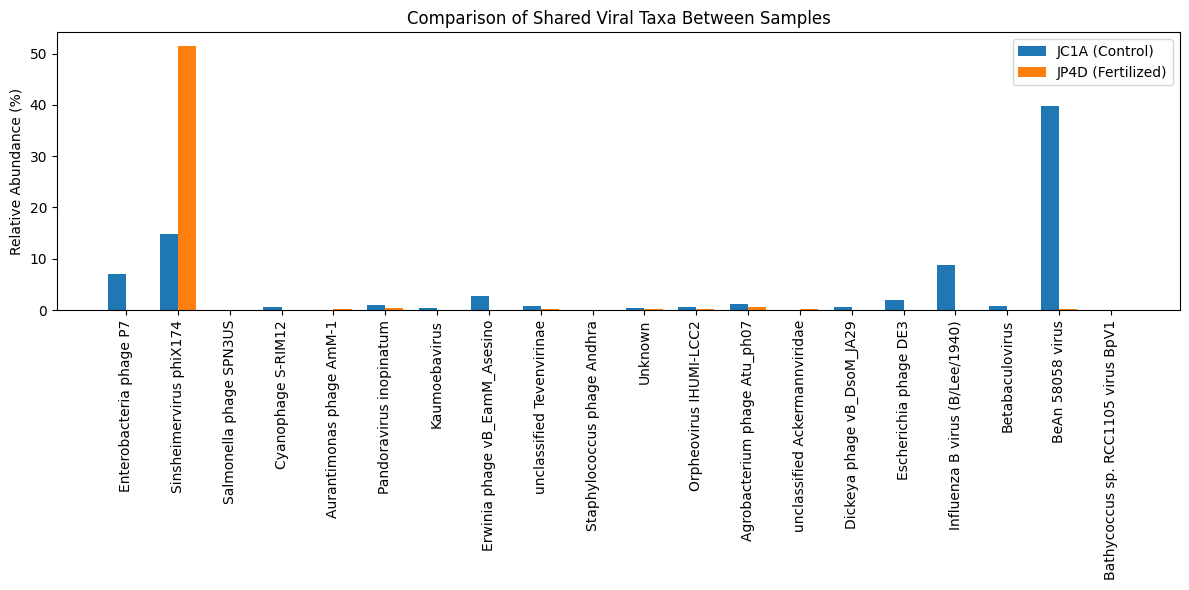

In [46]:
# Sort for readability
shared_df = shared.sort_values(by="percent_jc1a", ascending=False)

# Viruses names
labels = shared["name_txt"].fillna("Unknown").values

# Percents
jc1a = shared["percent_jc1a"].values
jp4d = shared["percent_jp4d"].values

# Index for each viruses
x = np.arange(len(labels))

# Width of bar
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Barres JC1A
rects1 = ax.bar(x - width/2, jc1a, width, label="JC1A (Control)", color="#1f77b4")

# Barres JP4D
rects2 = ax.bar(x + width/2, jp4d, width, label="JP4D (Fertilized)", color="#ff7f0e")

# Labels and title
ax.set_ylabel("Relative Abundance (%)")
ax.set_title("Comparison of Shared Viral Taxa Between Samples")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.legend()

# Setting
plt.tight_layout()

# Display plot
plt.show()


#### **Interpretation of Shared Viral Taxa:**

The comparative analysis of the viromes between the oligotrophic sample (JC1A) and the nutrient-enriched sample (JP4D) reveals marked differences in specific composition. Certain viruses, such as Sinsheimervirus phiX174, are present in both environments but show large differences in relative abundance (51.55% in JP4D vs. 14.93% in JC1A). Conversely, BeAn 58058 virus is highly dominant in JC1A (39.82%) while almost absent from JP4D. The presence of species specific to each condition suggests that nutrient enrichment significantly shapes the taxonomic structure of viral communities.



#### **conclusion**
The results highlight that nutrient enrichment substantially alters the taxonomic structure of viral communities. Certain viral species, such as Sinsheimervirus phiX174, become dominant after fertilization, whereas others, notably BeAn 58058 virus or Influenza B virus, are much more represented under oligotrophic conditions.

This redistribution of abundances suggests that nutrient availability strongly influences viral ecosystems, likely through changes in the abundance and composition of bacterial hosts. These preliminary observations warrant a more in-depth quantitative exploration of viral diversity using ecological indices, which will constitute the next stage of this work.

---

## VI. Quantitative exploration
##### **Objective:** Quantitative exploration with Ecological Diversity Indices (Shannon and Simpson indices) and Bray-Curtis Distance

#### **A- Ecological Diversity Indices: Shannon and Simpson indices**

In [58]:
#-------------------Ecologist Diversity index tools------------------------------------------
def compute_shannon(counts):
    """
    Compute Shannon diversity index for an array of counts.
    """
    shannon = -np.sum(counts * np.log(counts))
    return shannon

def compute_simpson(counts):
    """
    Compute Simpson diversity index for an array of counts.
    """
    simpson = 1 - np.sum(counts ** 2)
    return simpson


In [59]:
# Get percent for JC1A 
jc1a_counts = jc1a_annoted['percent'].values / 100

# Get counts for JP4D 
jp4d_counts = jp4d_annoted['percent'].values / 100

# Compute diversity indices for JC1A
shannon_jc1a = compute_shannon(jc1a_counts)
simpson_jc1a = compute_simpson(jc1a_counts)

# Compute diversity indices for JP4D
shannon_jp4d = compute_shannon(jp4d_counts)
simpson_jp4d = compute_simpson(jp4d_counts)

# Display the results
print("=== Diversity Indices ===")
print(f"JC1A - Shannon: {shannon_jc1a:.3f}, Simpson: {simpson_jc1a:.3f}")
print(f"JP4D - Shannon: {shannon_jp4d:.3f}, Simpson: {simpson_jp4d:.3f}")

=== Diversity Indices ===
JC1A - Shannon: 2.400, Simpson: 0.803
JP4D - Shannon: 3.581, Simpson: 0.733


#### **Interpretation**
The Shannon index revealed higher viral diversity in the fertilized (JP4D) environment compared to the control (JC1A). However, the Simpson index suggests a slightly higher evenness in JC1A, possibly due to the dominance of a few highly abundant viral taxa in JP4D.

#### **Conclusion**
These results indicate that nutrient enrichment in the aquatic environment contributed to an overall increase in viral diversity, as measured by the Shannon index. However, the slight decrease in evenness (Simpson index) suggests that certain viral taxa became dominant, reflecting a differential response of species to nutrient inputs.

### **B. Bray-Curtis and Heatmap Analysis**

In [60]:
from scipy.spatial.distance import braycurtis

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [68]:
# 2. Préparer les vecteurs d'abondance relative
vec_jc1a = comparison_taxon['percent_jc1a'].values
vec_jp4d = comparison_taxon['percent_jp4d'].values

# Compute Bray-Curtis distance
bray_curtis_distance = braycurtis(vec_jc1a, vec_jp4d)
print(f"Bray-Curtis dissimilarity between JC1A and JP4D: {bray_curtis_distance:.4f}")

Bray-Curtis dissimilarity between JC1A and JP4D: 0.8231


#### **Interpretation**
The Bray-Curtis dissimilarity between JC1A and JP4D is 0.8231.
This value is close to 1, indicating that the two viral communities have highly dissimilar taxonomic compositions in terms of relative abundances. In other words, nutrient enrichment appears to have substantially altered the profile of viruses in the fertilized environment compared to the control.

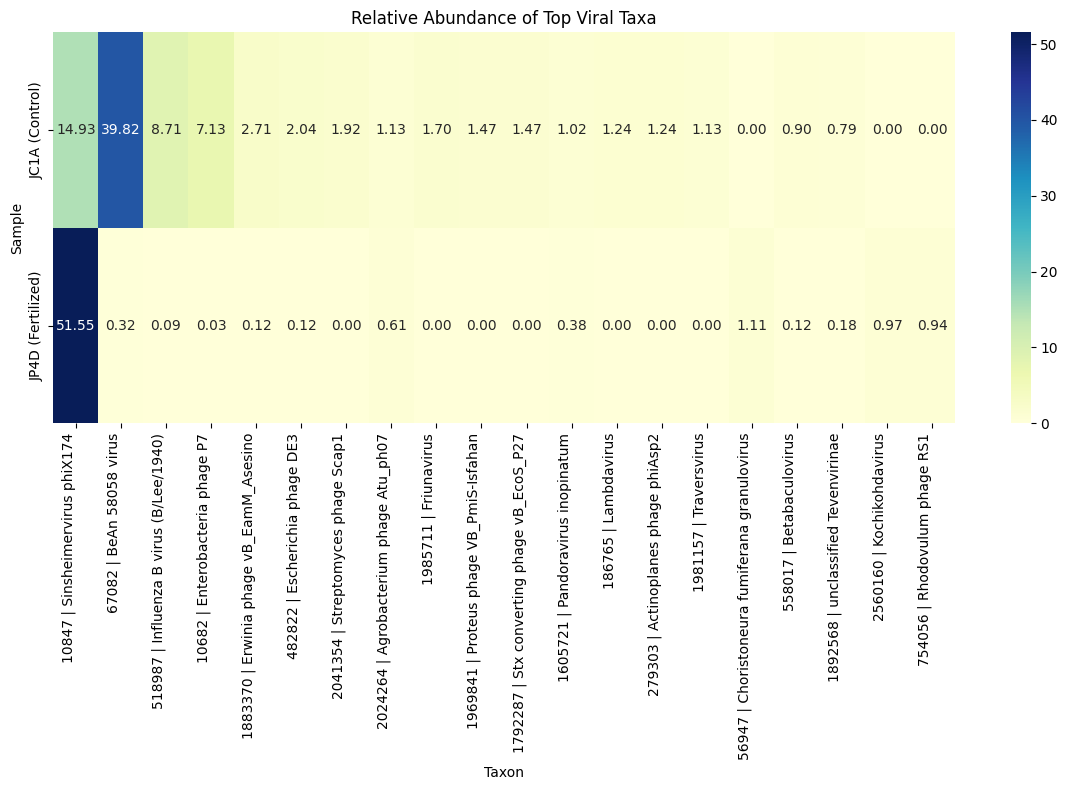

In [69]:
# Select the N most abundant taxa based on the total abundance across both samples
N = 20 
comparison_taxon["total_percent"] = comparison_taxon["percent_jc1a"] + comparison_taxon["percent_jp4d"]
top_taxa = comparison_taxon.sort_values("total_percent", ascending=False).head(N)

# Prepare the relative abundance vectors for the filtered taxa
vec_jc1a = top_taxa["percent_jc1a"].values
vec_jp4d = top_taxa["percent_jp4d"].values

# Recreate the abundance matrix for the heatmap
abundance_matrix = np.array([vec_jc1a, vec_jp4d])

# Create clear labels combining tax_id and taxon name
labels = top_taxa["tax_id"].astype(str) + " | " + top_taxa["name_txt"].fillna("Unknown")

# Generate the heatmap
plt.figure(figsize=(12, 8))  # Wider figure for readability
sb.heatmap(
    abundance_matrix,
    annot=True,                # Show numeric annotations inside the cells
    fmt=".2f",                 # Format with 2 decimal places
    yticklabels=["JC1A (Control)", "JP4D (Fertilized)"],
    xticklabels=labels,
    cmap="YlGnBu"              # Color palette
)

# Customize title and axes
plt.title("Relative Abundance of Top Viral Taxa")
plt.xlabel("Taxon")
plt.ylabel("Sample")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha="right")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the heatmap
plt.show();

#### Heatmap Interpretation
The heatmap displays the distribution of the relative abundances of the main viral taxa in the two samples:
- JC1A (Control)
- JP4D (Fertilized)

Key observations:

**--> Contrasting dominance**

In the JP4D sample, a single taxon (Sinsheimervirus phiX174) accounts for over 50% of the total abundance.

In JC1A, the distribution is more balanced, with several taxa each exceeding 5–10% relative abundance (BeAn 58058 virus, Influenza B virus, Enterobacteria phage P7).

**--> Specific or nearly absent taxa**

Some viruses such as Streptomyces phage Scap1, Stx converting phage vB_EcoS_P27, and Friunavirus are almost absent from JP4D.

Others, like Sinsheimervirus phiX174, show a strong increase in abundance under fertilized conditions.

**--> Overall reduction in diversity**

The dominance of a small number of taxa in JP4D aligns with the lower Simpson index, reflecting a reduced effective diversity.

**--> Signature of a nutrient enrichment effect**

These differences suggest that fertilization has led to ecological selection, favoring a few opportunistic viruses at the expense of a more diverse community.



#### Conclusion Bray-Curtis Distance and Heatmap
The high Bray-Curtis dissimilarity and the visual dominance of a few viral taxa in the fertilized sample (JP4D) reinforce the hypothesis that nutrient enrichment substantially alters viral community composition and reduces evenness. These findings support the interpretation of a strong selective pressure driving shifts toward less diverse, opportunistic viral assemblages under fertilization.

---

## Conclusion
This preliminary analysis compared the taxonomic composition and diversity of viral communities between a control aquatic environment and one subjected to nutrient enrichment. Overall, the results, alpha diversity metrics (Shannon and Simpson indices), Bray-Curtis dissimilarity, and visualization of relative abundances, indicate that fertilization strongly influences viral community structure, promoting the dominance of specific taxa and a reduction in overall evenness. These preliminary results represent a first stage of analysis, conducted in a perspective consistent with the standards of an advanced training program in bioinformatics. Additional investigations, including more advanced statistical testing and functional exploration of the viromes, could further refine and validate these trends.

<hr style="margin-top: 50px;">

<footer style="text-align: center; font-size: small; color: gray;">
  © 2025 Mbock Mbock Georges Christian 
  <br> This notebook was Independently prepared as part of my application for the MSc in Bioinformatics of Infectious Diseases and Pathogen Genomics at    <br> Stellenbosch University (African STARS Program).  
    <br>All analyses are preliminary and intended to demonstrate methodological skills and scientific reasoning.
</footer>

---